In [93]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.integrate import solve_ivp
import scipy.interpolate as interpolate
from glob import glob
from tools import unique_maxs, local_max
from datetime import datetime as dt
import pytz # for seting datetime timezone

In [6]:
p = np.abs(np.fft.rfft(V1))**2 #xdat is in volts and power = V^2 / R so is perportional up to a resistance
f = np.linspace(0,1/(np.min(np.diff(t))*2),len(p))
idx = np.argsort(f)

plt.plot(f[idx], p[idx],linewidth = 0.3)
plt.yscale("log")

#plt.plot(freqs[idx], p[idx],linewidth = 0.3)
#freqs = np.fft.fftfreq(x_dat.size, timestep)
#plt.xscale("log")
plt.xlim((0,40))

NameError: name 'V1' is not defined

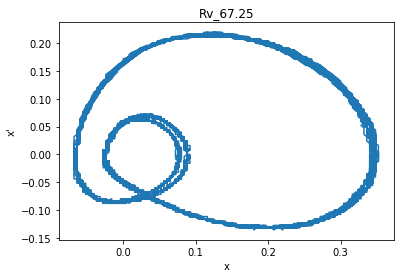

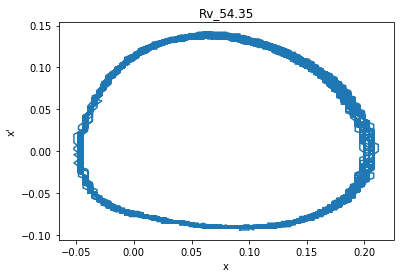

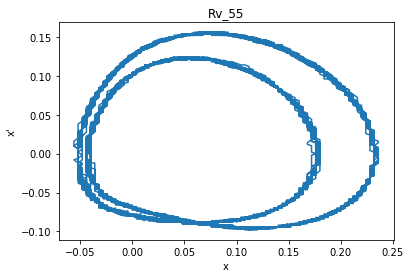

[<AxesSubplot:title={'center':'Rv_67.25'}, xlabel='x', ylabel="x'">,
 <AxesSubplot:title={'center':'Rv_54.35'}, xlabel='x', ylabel="x'">,
 <AxesSubplot:title={'center':'Rv_55'}, xlabel='x', ylabel="x'">]

In [24]:

# define fxn
# inputs:
#  - filename
#  - plot? BOOL
#  - maybe other args as we work on it
# Goal of this fxn is to make time series, phase, and spectral density plots, return them on their own axis. If plot set to true then plot them,

def phase_diagram_data(filenames, directory = None):
    '''takes filenames as an argument and generate the phase diagrams for them seperately'''
    # spectral density is the power spectrum thing
    # okay I would just copy paste the code lol if you get it then you should do it, I'm gonna write the save thing, I'll just have it take a directory
    # i can do that if youd like
    axs = []
    
    
    if type(filenames) != np.array and type(filenames) != list:
        filenames = [filenames]

    for filename in filenames:
        fig, ax = plt.subplots()
        axs.append(ax)
        t, negative_x_prime, x = np.genfromtxt(filename, delimiter = ',', unpack = True, skip_header = 12)
        x_prime = -negative_x_prime
        ax.plot(x, x_prime)
        ax.set(xlabel = 'x', ylabel = "x'", title = filename.split('/')[-1][:-4])
        
        if directory != None:
            plt.savefig(directory + '/phase_' + filename.split('/')[-1][:-4] + '.png')

        plt.show()

        #repeat the above but with fft! or we can make them into subplots not sure how good the phase plot will look tho


    return axs 


# define fxn

phase_diagram_data(filenames[:3], )

# haha what do you think?
# We should plot datapoints in my opinion

[67.25, 54.35, 55.0, 100.0, 60.0, 54.6, 67.0, 54.1, 69.0, 54.25, 67.5, 70.0, 110.0, 67.125, 68.0, 66.0, 54.7, 66.5, 54.0, 54.4, 65.0, 54.3, 50.0, 90.0, 80.0, 54.2, 54.5, 120.0, 40.0, 55.5]
[[0.076, 0.08, 0.088, 0.092, 0.344, 0.348, 0.352], [0.2, 0.204, 0.208, 0.212], [0.176, 0.18, 0.232, 0.236], [0.032, 0.04, 0.048, 0.056, 0.09599999, 0.136, 0.144, 0.168, 0.184, 0.2, 0.216, 0.224, 0.232, 0.24, 0.248, 0.264, 0.28, 0.296, 0.304, 0.312, 0.32, 0.328, 0.336, 0.344, 0.352, 0.36, 0.368, 0.376, 0.384, 0.392, 0.4, 0.408, 0.416, 0.424, 0.432, 0.44, 0.448, 0.456, 0.464, 0.48, 0.496, 0.512, 0.52, 0.528, 0.536, 0.544, 0.552], [0.112, 0.116, 0.304], [0.192, 0.196, 0.216, 0.22], [0.084, 0.088, 0.344, 0.348], [0.2, 0.204, 0.208], [0.056, 0.124, 0.128, 0.328, 0.332, 0.364, 0.368], [0.2, 0.204, 0.208], [0.072, 0.09599999, 0.09999999, 0.34, 0.344, 0.352, 0.356], [0.052, 0.056, 0.128, 0.132, 0.332, 0.336, 0.372, 0.376], [0.08, 0.088, 0.224, 0.232, 0.48, 0.488, 0.592], [0.084, 0.088, 0.344, 0.348], [0.064,

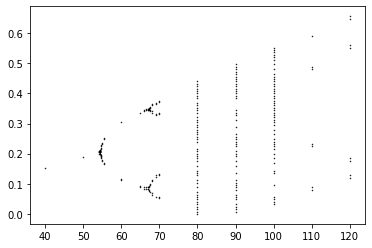

In [94]:
filenames = glob("/work/Data_experimental/Coarse_sweep1/*")

bifurcation = []
Rv_arr = []
data = {}
for filename in filenames:
    t, negative_x_prime, x = np.genfromtxt(filename, skip_header = 12, delimiter = ',', unpack = True)
    t = t - np.min(t)
    x_prime = -negative_x_prime

    Rv = float(filename.split('/')[-1][3:-4])
    Rv_arr.append(Rv)
    data[filename.split('/')[-1][:-4]] = (t,x)
    maxs = unique_maxs(x, N = 50)
    bifurcation.append(maxs)

print(Rv_arr)
print(bifurcation)
for Rv, bif in zip(Rv_arr, bifurcation):
    plt.plot(Rv*np.ones(len(bif)), bif, 'k.', markersize = 1)


tz = pytz.timezone('US/Pacific')
dateString = str(dt.now(tz).date())
plt.savefig("/work/Notes/Simulation/"+dateString+"-ExperimentalBifurcation_v1.svg",dpi = 600)

['/work/Data_experimental/Coarse_sweep1/Rv_54.5.txt', '/work/Data_experimental/Coarse_sweep1/Rv_54.6.txt', '/work/Data_experimental/Coarse_sweep1/Rv_54.7.txt', '/work/Data_experimental/Coarse_sweep1/Rv_55.txt']
[ 0.23982305 54.45593639 19.24605908]
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in power


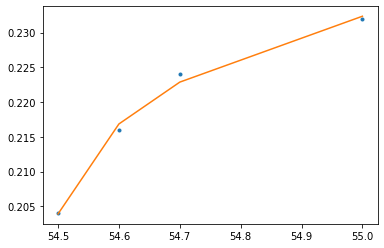

In [89]:
filenames2 = ["/work/Data_experimental/Coarse_sweep1/Rv_54.5.txt", "/work/Data_experimental/Coarse_sweep1/Rv_54.6.txt", 
                "/work/Data_experimental/Coarse_sweep1/Rv_54.7.txt","/work/Data_experimental/Coarse_sweep1/Rv_55.txt"]
print(filenames2)
data = []
Rv_arr = []
for filename in filenames2:
    t, negative_x_prime, x = np.genfromtxt(filename, skip_header = 12, delimiter = ',', unpack = True)
    t = t - np.min(t)
    x_prime = -negative_x_prime

    Rv = float(filename.split('/')[-1][3:-4])
    Rv_arr.append(Rv)
    
    
    maxs = min(unique_maxs(x, N = 500))
    data.append(maxs)

def sqrt_func(Rv, a, b, c):
    return a*(Rv - b)**(1/c)

plt.plot(Rv_arr, data, '.')

pOpt, pCov = curve_fit(sqrt_func, Rv_arr, data, p0 = [ 0.1447167, 52.58470484, 3])
print(pOpt)

plt.plot(Rv_arr, sqrt_func(Rv_arr, *pOpt))

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=4939151a-2261-4374-8b6d-a725368f8dc5' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>